# 🏦 Fraud Detection System for Banking Transactions

This notebook demonstrates a **complete end-to-end machine learning pipeline** for detecting fraudulent banking transactions using the **PaySim dataset (6.3M transactions)**.

### **Steps Covered**
1. Import Libraries & Setup
2. Load Dataset
3. Exploratory Data Analysis (EDA)
4. Data Preprocessing (Encoding, Scaling, SMOTE)
5. Model Training (XGBoost)
6. Model Evaluation (Accuracy, Recall, ROC-AUC)
7. Fraud Predictions (Manual & Random Samples)
8. Save Trained Model



In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
import pickle
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,5)


In [24]:
data_path = "data/PS_20174392719_1491204439457_log.csv"  # adjust if needed
df = pd.read_csv(data_path)
print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## 📊 1. Exploratory Data Analysis

Fraud Distribution:
 isFraud
0    6354407
1       8213
Name: count, dtype: int64
Fraud percentage: 0.13%


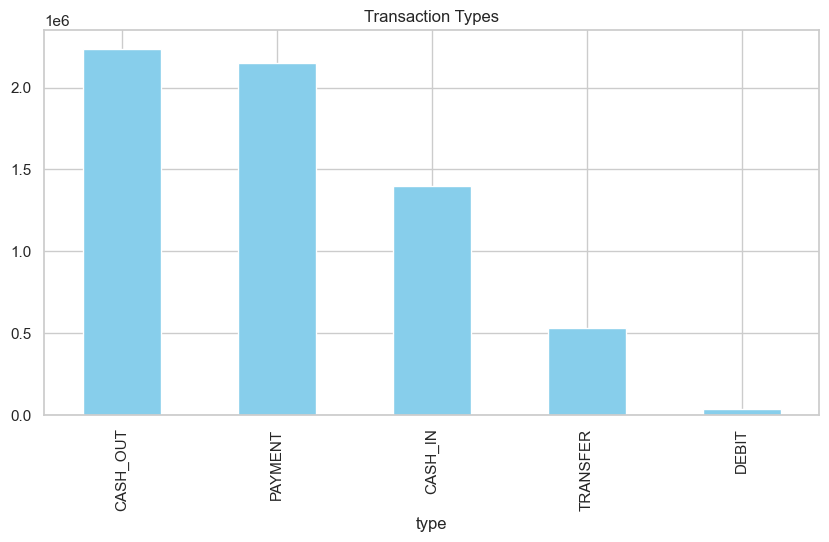

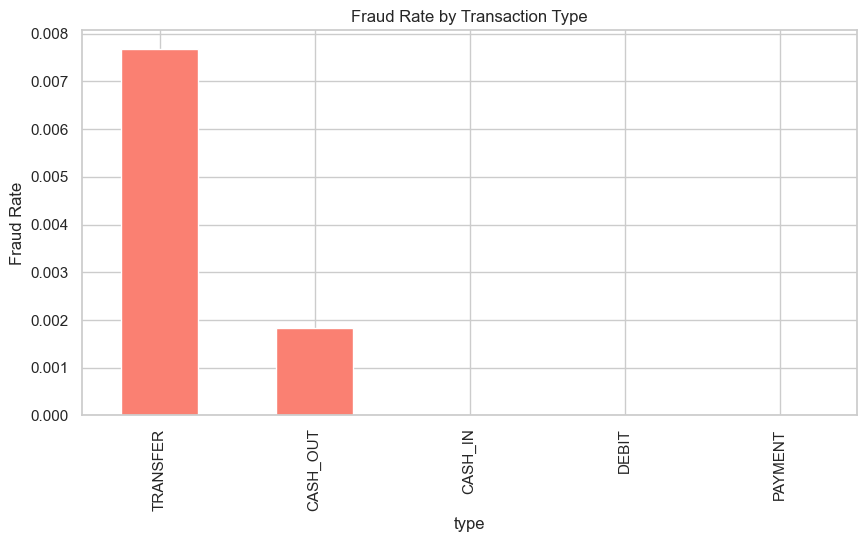

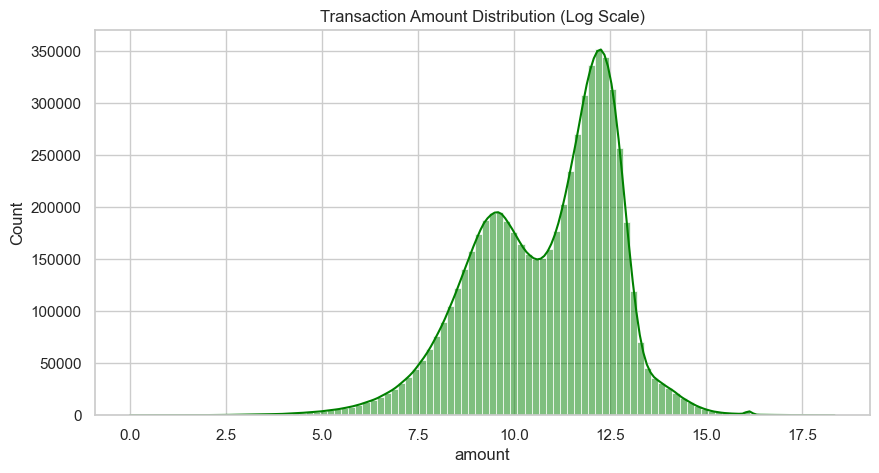

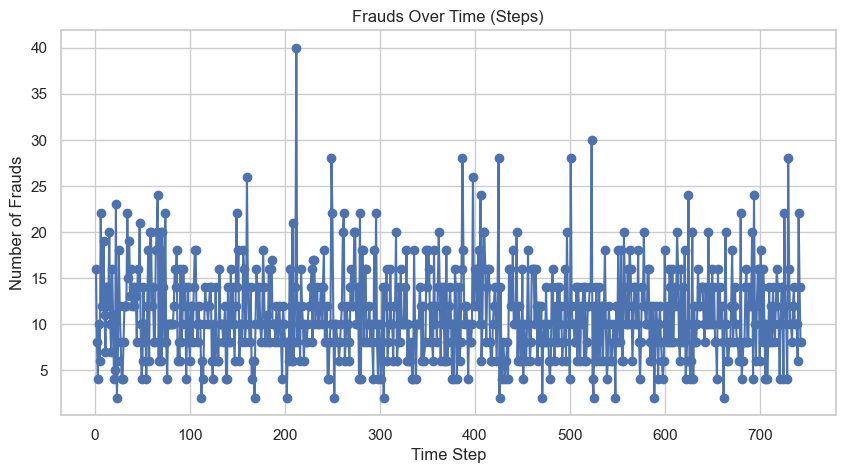

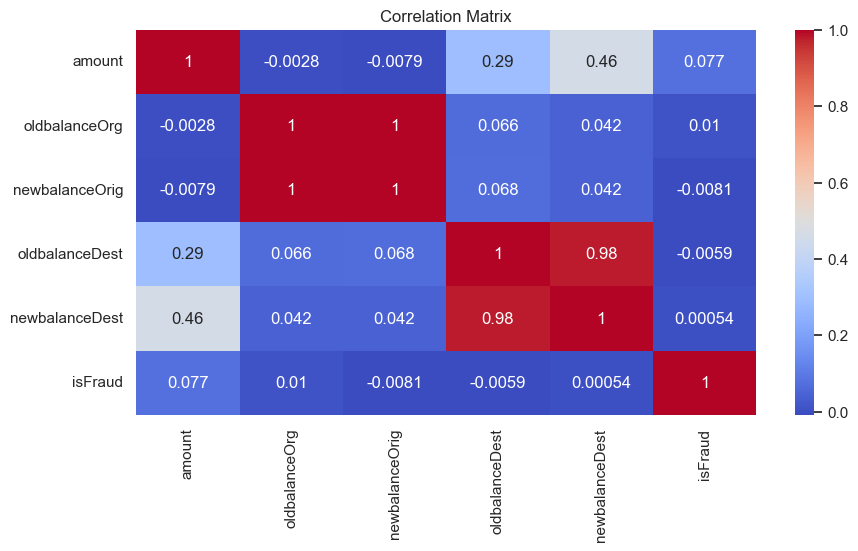

Suspicious zero-balance transactions: 1188074


In [25]:
# Fraud distribution
print("Fraud Distribution:\n", df['isFraud'].value_counts())
fraud_pct = round((df['isFraud'].sum()/df.shape[0])*100,2)
print(f"Fraud percentage: {fraud_pct}%")

# Transaction type counts
df['type'].value_counts().plot(kind='bar', color='skyblue', title='Transaction Types')
plt.show()

# Fraud rate by type
fraud_by_type = df.groupby('type')['isFraud'].mean().sort_values(ascending=False)
fraud_by_type.plot(kind='bar', color='salmon', title='Fraud Rate by Transaction Type')
plt.ylabel("Fraud Rate")
plt.show()

# Amount distribution (log scale)
sns.histplot(np.log1p(df['amount']), bins=100, kde=True, color='green')
plt.title("Transaction Amount Distribution (Log Scale)")
plt.show()

# Fraud over time
fraud_steps = df[df['isFraud']==1]['step'].value_counts().sort_index()
plt.plot(fraud_steps.index, fraud_steps.values, marker='o')
plt.title("Frauds Over Time (Steps)")
plt.xlabel("Time Step")
plt.ylabel("Number of Frauds")
plt.grid(True)
plt.show()

# Correlation matrix
corr = df[['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Suspicious zero-balance transfers
zero_after = df[(df["oldbalanceOrg"] > 0) &
                (df["newbalanceOrig"] == 0) &
                (df["type"].isin(["TRANSFER", "CASH_OUT"]))]
print("Suspicious zero-balance transactions:", len(zero_after))


## ⚙️ 2. Data Preprocessing

In [26]:
df_clean = df.drop(['nameOrig','nameDest','isFlaggedFraud'], axis=1)

# Encode 'type'
le = LabelEncoder()
df_clean['type'] = le.fit_transform(df_clean['type'])

# Features and target
X = df_clean.drop('isFraud', axis=1)
y = df_clean['isFraud']

# Handle imbalance
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_res, test_size=0.2, random_state=42, stratify=y_res)
print("Training Set:", X_train.shape)
print("Test Set:", X_test.shape)


Training Set: (10167051, 7)
Test Set: (2541763, 7)


## 🤖 3. Model Training (XGBoost)

In [27]:
model = xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1,
                         subsample=0.8, colsample_bytree=0.8, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]


## 📈 4. Model Evaluation

In [28]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
false_positive_rate = fp / (fp+tn)

print("✅ Accuracy:", accuracy)
print("✅ Precision:", precision)
print("✅ Recall:", recall)
print("✅ F1-Score:", f1)
print("✅ ROC-AUC:", roc_auc)
print("✅ False Positive Rate:", false_positive_rate)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", cm)


✅ Accuracy: 0.99780113252101
✅ Precision: 0.9968819508149339
✅ Recall: 0.9987260805693059
✅ F1-Score: 0.9978031636173393
✅ ROC-AUC: 0.9999520237197909
✅ False Positive Rate: 0.0031238147994857115

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270882
           1       1.00      1.00      1.00   1270881

    accuracy                           1.00   2541763
   macro avg       1.00      1.00      1.00   2541763
weighted avg       1.00      1.00      1.00   2541763

Confusion Matrix:
 [[1266912    3970]
 [   1619 1269262]]


## 🌟 5. Feature Importance

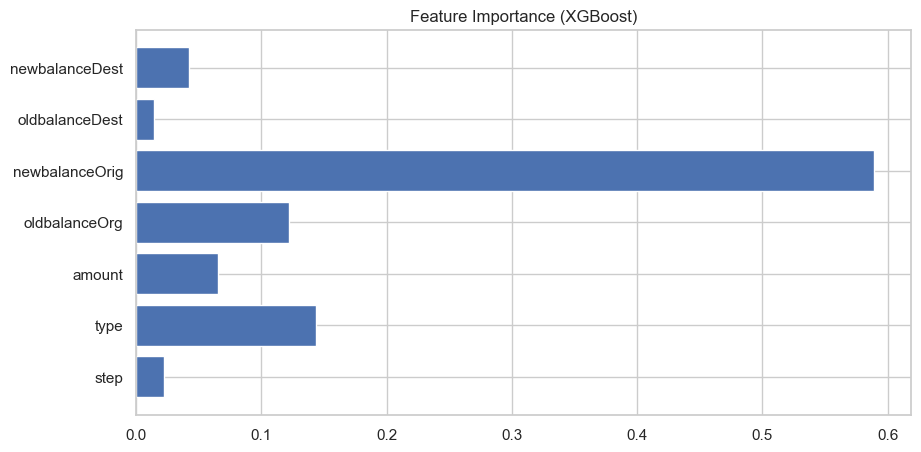

In [29]:
importances = model.feature_importances_
plt.barh(X.columns, importances)
plt.title("Feature Importance (XGBoost)")
plt.show()


## 🧾 6. Manual Transaction Prediction

In [31]:
import pandas as pd
import numpy as np

# Convert y_test to a DataFrame to combine with X_test
y_test_series = pd.Series(y_test).reset_index(drop=True)
X_test_df = pd.DataFrame(X_test).reset_index(drop=True)

# Find the first row where fraud = 1
fraud_pos = y_test_series[y_test_series == 1].index[0]

# Select corresponding sample
fraud_sample = X_test_df.iloc[fraud_pos].values.reshape(1, -1)

# Predict
pred = model.predict(fraud_sample)[0]
prob = model.predict_proba(fraud_sample)[0][1]
print("Fraud Prediction:", pred, "| Probability:", round(prob, 4))


Fraud Prediction: 1 | Probability: 1.0


## 🧾Random Sample Test (5 Transactions)

,0,1,2,3,4,5,6,Fraud_Prediction,Fraud_Probability
411713,-1.558964,-1.423393,-0.320903,2.744860,3.944929,-0.031135,-0.213507,0,0.000002
558399,-1.651175,-0.746893,-0.367132,-0.381495,-0.209014,0.441513,0.301767,0,0.000303
822399,-0.025965,-0.746893,-0.430509,-0.381495,-0.209014,0.602936,0.408629,0,0.001086
991749,-0.365991,-0.746893,4.853638,2.657570,-0.209014,4.029870,6.215559,1,0.999978
1089995,-1.345728,-0.746893,0.107243,-0.066897,-0.209014,-0.152145,0.037549,1,0.999994


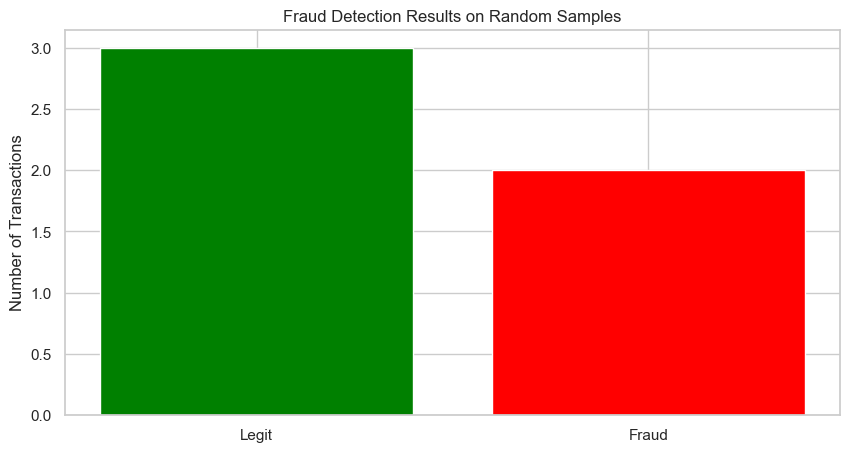

In [32]:
sample_df = pd.DataFrame(X_test).sample(5, random_state=42)
preds = model.predict(sample_df)
probs = model.predict_proba(sample_df)[:, 1]

result = sample_df.copy()
result['Fraud_Prediction'] = preds
result['Fraud_Probability'] = probs.round(6)
display(result)

plt.bar(['Legit', 'Fraud'], [(preds==0).sum(), (preds==1).sum()],
        color=['green', 'red'])
plt.title("Fraud Detection Results on Random Samples")
plt.ylabel("Number of Transactions")
plt.show()


## 💾 7. Save Model

In [33]:

# Save model
model_path = os.path.join( "models", "fraud_model.pkl")
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)
print(f"✅ Model saved as {model_filename}")


✅ Model saved as fraud_model.pkl
